# Tutorial: Morpho problem setup

In [7]:
# install dependecies
!pip install -U nevergrad

## Load modules

In [8]:
import nevergrad as ng
import matplotlib.pyplot as plt
import numpy as np

## Define the cost function
The morpho testcase corresponds to the minimization of the blue specular reflection provided by a 2D grating. The 600 nm period is constituted of 5 number of layers with 1 block of matter (of permittivity 2.4336). Each block is characterized by its width, thickness, and position in the period. The optical properties of the grating are computed with a RCWA method.

In [9]:
i = complex(0,1)

### RCWA functions
def cascade(T,U):
    n=int(T.shape[1]/2)
    J=np.linalg.inv(np.eye(n)-np.matmul(U[0:n,0:n],T[n:2*n,n:2*n]))
    K=np.linalg.inv(np.eye(n)-np.matmul(T[n:2*n,n:2*n],U[0:n,0:n]))
    S=np.block([[T[0:n,0:n]+np.matmul(np.matmul(np.matmul(T[0:n,n:2*n],J),U[0:n,0:n]),T[n:2*n,0:n]),np.matmul(np.matmul(T[0:n,n:2*n],J),U[0:n,n:2*n])],[np.matmul(np.matmul(U[n:2*n,0:n],K),T[n:2*n,0:n]),U[n:2*n,n:2*n]+np.matmul(np.matmul(np.matmul(U[n:2*n,0:n],K),T[n:2*n,n:2*n]),U[0:n,n:2*n])]])
    return S

def c_bas(A,V,h):
    n=int(A.shape[1]/2)
    D=np.diag(np.exp(1j*V*h))
    S=np.block([[A[0:n,0:n],np.matmul(A[0:n,n:2*n],D)],[np.matmul(D,A[n:2*n,0:n]),np.matmul(np.matmul(D,A[n:2*n,n:2*n]),D)]])
    return S

def marche(a,b,p,n,x):
    from scipy.linalg import toeplitz
    l=np.zeros(n,dtype=np.complex128)
    m=np.zeros(n,dtype=np.complex128)
    tmp=1/(2*np.pi*np.arange(1,n))*(np.exp(-2*1j*np.pi*p*np.arange(1,n))-1)*np.exp(-2*1j*np.pi*np.arange(1,n)*x)
    l[1:n]=1j*(a-b)*tmp
    l[0]=p*a+(1-p)*b
    m[0]=l[0]
    m[1:n]=1j*(b-a)*np.conj(tmp)
    T=toeplitz(l,m)
    return T

def creneau(k0,a0,pol,e1,e2,a,n,x0):
    nmod=int(n/2)
    alpha=np.diag(a0+2*np.pi*np.arange(-nmod,nmod+1))
    if (pol==0):
        M=alpha*alpha-k0*k0*marche(e1,e2,a,n,x0)
        L,E=np.linalg.eig(M)
        L=np.sqrt(-L+0j)
        L=(1-2*(np.imag(L)<-1e-15))*L
        P=np.block([[E],[np.matmul(E,np.diag(L))]])
    else:
        U=marche(1/e1,1/e2,a,n,x0)
        T=np.linalg.inv(U)
        M=np.matmul(np.matmul(np.matmul(T,alpha),np.linalg.inv(marche(e1,e2,a,n,x0))),alpha)-k0*k0*T
        L,E=np.linalg.eig(M)
        L=np.sqrt(-L+0j)
        L=(1-2*(np.imag(L)<-1e-15))*L
        P=np.block([[E],[np.matmul(np.matmul(U,E),np.diag(L))]])
    return P,L

def homogene(k0,a0,pol,epsilon,n):
    nmod=int(n/2)
    valp=np.sqrt(epsilon*k0*k0-(a0+2*np.pi*np.arange(-nmod,nmod+1))**2+0j)
    valp=valp*(1-2*(valp<0))*(pol/epsilon+(1-pol))
    P=np.block([[np.eye(n)],[np.diag(valp)]])
    return P,valp

def interface(P,Q):
    n=int(P.shape[1])
    S=np.matmul(np.linalg.inv(np.block([[P[0:n,0:n],-Q[0:n,0:n]],[P[n:2*n,0:n],Q[n:2*n,0:n]]])),np.block([[-P[0:n,0:n],Q[0:n,0:n]],[P[n:2*n,0:n],Q[n:2*n,0:n]]]))
    return S

### Cost function
def cost_morpho(x):
    lam_blue = 449.5897
    pol = 1
    d = 600.521475
    nmod = 25
    e2 = 2.4336
    n = 2 * nmod + 1
    n_motifs = int(x.size / 3)
    x = x / d
    h = x[n_motifs : 2*n_motifs]
    x0 = x[2 * n_motifs : 3 * n_motifs]
    a = x[0:n_motifs]
    spacers = np.zeros(a.size)

    #Maximization of the blue specular reflection
    l = lam_blue / d
    k0 = 2 * np.pi / l
    P, V = homogene(k0, 0, pol, 1, n)
    S = np.block([[np.zeros([n, n]), np.eye(n, dtype=np.complex128)], [np.eye(n), np.zeros([n, n])]])
    for j in range(0, n_motifs):
        Pc, Vc = creneau(k0, 0, pol, e2, 1, a[j], n, x0[j])
        S = cascade(S, interface(P, Pc))
        S = c_bas(S, Vc, h[j])
        S = cascade(S, interface(Pc, P))
        S = c_bas(S, V, spacers[j])
    Pc, Vc = homogene(k0, 0, pol, e2, n)
    S = cascade(S, interface(P, Pc))
    R = np.zeros(3, dtype=float)
    for j in range(-1, 2):
        R[j] = abs(S[j + nmod, nmod]) ** 2 * np.real(V[j + nmod]) / k0
    cost = 1 - (R[-1] + R[1]) / 2 + R[0] / 2

    return(cost)

## Setting up the optimization problem

Now we define the specific configuration of our optimization problem. We parametrize the minimum and maximum values of the width, thickness, and position of each blocks.

In [10]:
nb_layers = 5
min_w = 0
max_w = 600
min_thick = 0
max_thick = 200
min_p = 0
max_p = 600

## Setup the Nevergrad optimizer

Now we set up the parametrization for nevergrad (this is called *parametrization*).
Finally, we configure the optimizer.

In [13]:
budget = 10000
N_population = 30

parametrization = ng.p.Array(
    shape=(3*nb_layers,),
    lower=[min_w]*nb_layers + [min_thick]*nb_layers + [min_p]*nb_layers,
    upper=[max_w]*nb_layers + [max_thick]*nb_layers + [max_p]*nb_layers,
)

optim_algos_DE = ng.optimizers.registry['DE']
optimizer = optim_algos_DE(parametrization, budget=budget)
optimizer.register_callback("tell", ng.callbacks.ProgressBar())

## Run the optimization

Running the optimization is straightforward. We simply pass the cost function (`cost_morpho`) to the `minimize` function of the optimizer. The problem is configured inside the optimzer object and cost function.

In [14]:
x_opt = optimizer.minimize(cost_morpho)

100%|██████████| 10000/10000 [20:07<00:00, 11.73it/s]

## Analyze the result

Finally, we calculate the cost for the final best solution:

In [15]:
x = x_opt.value
print(x)
cf_x = cost_morpho(x)
print(cf_x)

[284.19369574 381.84007596 272.73926645 398.09426669 253.01836914
  80.27229325 104.22319201  96.49311247  91.7642368  107.15729202
 178.58066006 430.0128144  184.3016804  421.89228113 194.17604152]
0.7368004297041006


Then we vizualize the spectrum associated with this final best solution:



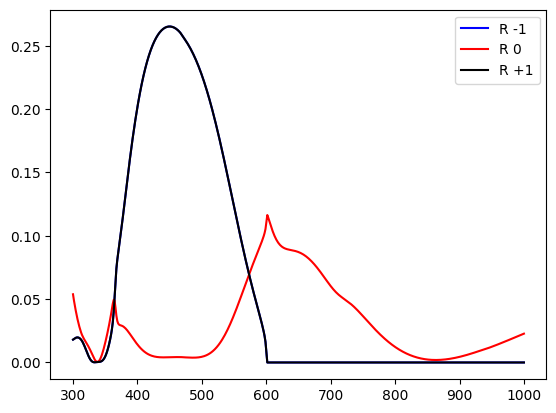

In [16]:
def R_morpho(x, lam):
    pol = 1
    d = 600.521475
    nmod = 25
    e2 = 2.4336
    n = 2 * nmod + 1
    n_motifs = int(x.size / 3)
    x = x / d
    h = x[n_motifs : 2*n_motifs]
    x0 = x[2 * n_motifs : 3 * n_motifs]
    a = x[0:n_motifs]
    spacers = np.zeros(a.size)

    #Reflexion
    l = lam / d
    k0 = 2 * np.pi / l
    P, V = homogene(k0, 0, pol, 1, n)
    S = np.block([[np.zeros([n, n]), np.eye(n, dtype=np.complex128)], [np.eye(n), np.zeros([n, n])]])
    for j in range(0, n_motifs):
        Pc, Vc = creneau(k0, 0, pol, e2, 1, a[j], n, x0[j])
        S = cascade(S, interface(P, Pc))
        S = c_bas(S, Vc, h[j])
        S = cascade(S, interface(Pc, P))
        S = c_bas(S, V, spacers[j])
    Pc, Vc = homogene(k0, 0, pol, e2, n)
    S = cascade(S, interface(P, Pc))
    R = np.zeros(3, dtype=float)
    for j in range(-1, 2):
        R[j] = abs(S[j + nmod, nmod]) ** 2 * np.real(V[j + nmod]) / k0
    cost = 1 - (R[-1] + R[1]) / 2 + R[0] / 2

    return(R)

wavelengths = np.linspace(300,1000,500)
R_m1 = np.empty(wavelengths.size)
R_p1 = np.empty(wavelengths.size)
R_0 = np.empty(wavelengths.size)

for k in range(wavelengths.size):
    R = R_morpho(x, wavelengths[k])
    R_m1[k] = R[-1]
    R_p1[k] = R[1]
    R_0[k] = R[0]

plt.figure(1)
plt.plot(wavelengths, R_m1, "b", label = "R -1")
plt.plot(wavelengths, R_0, "r", label = "R 0")
plt.plot(wavelengths, R_p1, "k", label = "R +1")
plt.legend()
plt.show()

And now, we represent the final geometry of the solution

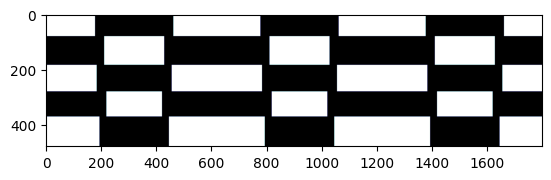

In [17]:
def show_structure(x):
    number_layers = 5
    n_cubes = 1
    d = 600.521475
    n_motifs = int(x.size / 3)
    t = x[n_motifs : 2*n_motifs]
    w = x[0:n_motifs]
    p = x[2 * n_motifs : 3*n_motifs]

    X = np.array([t, w, p])
    X = X.T

    h = t/d
    x = X/d

    n = 600
    H = sum(h)
    M0 = np.zeros((n))
    for j in range(number_layers):
        tmp = np.zeros(n)
        position = np.arange(1,n+1)/n
        for k in range(int((X.shape[1]-1)/2)):
            tmp = tmp + (position>x[j,2*k+2])*(position<x[j,2*k+1]+x[j,2*k+2])
        if (x[j,2*k+1]+x[j,2*k+2]>1):
            tmp = tmp + (position<x[j,2*k+1]+x[j,2*k+2]-1)
        cst = int(np.floor(h[j]*n))
        M2 = np.tile(tmp,(cst,3))
        if (j == 0):
            M = M2
        else:
            M = np.vstack((M,M2))

    M = 1 - M
    return M

M = show_structure(x)
plt.figure(2)
plt.imshow(M*127, cmap = 'bone')
plt.show(block = False)